### **1 .Importing the necessary libraries**

In [53]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib
import xgboost
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

%matplotlib inline
sns.set_style('darkgrid')

### **2. Loading and Reading the dataset**

In [54]:
df = pd.read_csv('Fraud.csv')

In [55]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [56]:
df.shape

(6362620, 11)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [58]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


### **3. Exploratory Data Analysis and Preprocessing**

In [59]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

* Looks like there are **no missing values** in this dataset.
* But the balances of the reciever before and after the transactions **(oldbalanceDest and newbalanceDest)** are '0' for transactions to a merchant.
* **They can be considered as missing values**. This will be handled a little later on.

In [60]:
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

* Only 0.001% of the transactions in this dataset are fraudulent.
* This dataset is highly imbalanced.
* This is the dependent variable that is to be predicted to mark transactions as fraudulent.

#### **A. Deciding which variables/features to keep**

* The features that have to be present in the dataset are: **type**, **oldbalanceOrg**, **newbalanceOrig**, **oldbalanceDest**, **newbalanceDest**, and **isFraud**.
* The reasoning for excluding the remaining ones are as follows.

**step**

In [61]:
df = df.drop(columns = ['step'])

* Firstly the **step** variable which indicates at what time the transaction has taken place.
* This feature does not help in deciding fraudulent transactions **as a fraud can happen at any time**.

**isFlaggedFraud**

In [62]:
df.isFlaggedFraud.value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [63]:
df[df.isFlaggedFraud==1]

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


In [64]:
df = df.drop(columns = ['isFlaggedFraud'])

* **Only 16 transactions** are flagged as fraududent. 
* With the data above it can be seen that in all of the 'isFlaggedFraud' transactions, the person is trying to cash out all funds to a new account via a TRANSFER while the balance of the sender remains the same.
* But because so **few data points** are present, it is **not wise to include while training**.
* These transactions are **already marked as fraudulent in the 'isFraud' column**, so we can hope the model find this relationship without the 'isFlaggedFraud' column

**nameOrig** and **nameDest**

In [65]:
df[df['nameDest'].str.startswith('M')]

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0
5,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0
6,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
6362312,PAYMENT,8178.01,C1213413071,11742.0,3563.99,M1112540487,0.0,0.0,0
6362314,PAYMENT,17841.23,C1045048098,10182.0,0.00,M1878955882,0.0,0.0,0
6362316,PAYMENT,1022.91,C1203084509,12.0,0.00,M675916850,0.0,0.0,0
6362318,PAYMENT,4109.57,C673558958,5521.0,1411.43,M1126011651,0.0,0.0,0


In [66]:
df[df['nameOrig'].str.startswith('M')]

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud


* As can be seen above, there are **no senders that are Merchants** but **2 million of the receivers are Merchants**.
* There is **no information** about the receivers balances, **when the transaction is with a merchant**.
* So this data can be considered as **missing data**.
* I did train models excluding this data, but that resulted in **significanly worse results**.
* So this **data will be included in training** the models.


* The 'nameOrig' and 'nameDest' columns are **not useful** because it does not matter who transacts with whom (unless with a merchant). 
* Maybe the columns values can be changed, where if the receiver/sender is a customer, the value can be '1', and '0' for a merchant.
* I also tried this, but it **resulted in insignificant improvements** to the the metrics with **very low feature importance**.
* So for now, **I will be excluding these two columns for a little more simplicity**.

In [67]:
df = df.drop(columns = ['nameOrig', 'nameDest'])

In [68]:
df

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0
1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0
2,TRANSFER,181.00,181.00,0.00,0.00,0.00,1
3,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1
4,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0
...,...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1
6362616,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1
6362617,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1
6362618,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1


#### **B. Finding Correlations**

Text(0.5, 1.0, 'Heatmap of Correlations')

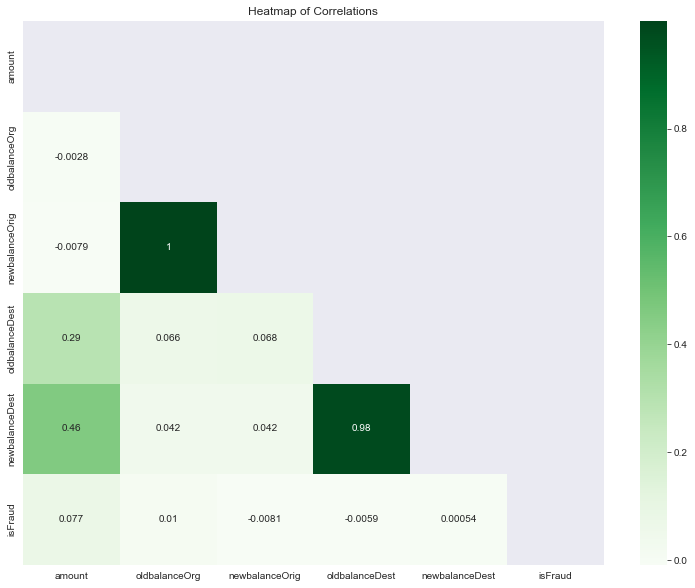

In [69]:
plt.figure(figsize = (13,10))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), cmap = 'Greens', annot = True, mask=matrix)
plt.title('Heatmap of Correlations') 

* There is **some correlation** between the 'amount' and the 'newbalanceDest' and 'oldbalanceDest', since the amount transacted is reflected in the receivers account.
* However a correlation should have been possible for the senders account as well('newbalanceOrig' and 'oldbalanceOrg'), but that is not the case.
* Theres is a **strong correlation is between the sender's balance before and after the transaction ('newbalanceOrig' and 'oldbalanceOrg')**, this does make sense as they are quite similar due to a large quantity of transactions being fairly low in 'amount'(shown in the boxplot below).
* Similarly, there is a **strong correlation is between the receivers's balance before and after the transaction ('newbalanceDest' and 'oldbalanceDest')**.

#### **C. Handling Outliers**

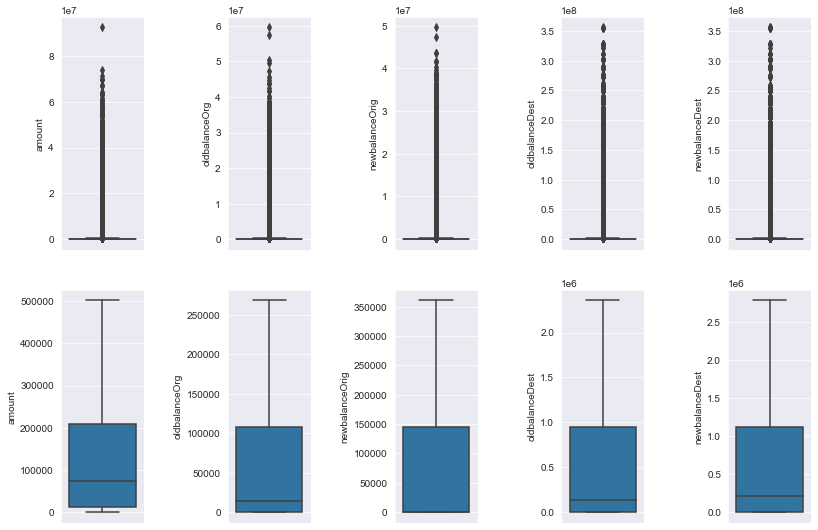

In [70]:
fig, axes = plt.subplots(2,5, figsize = (12,8))
  
sns.boxplot(y=df.amount , ax=axes[0][0])
sns.boxplot(y=df.oldbalanceOrg , ax=axes[0][1])
sns.boxplot(y=df.newbalanceOrig , ax=axes[0][2])
sns.boxplot(y=df.oldbalanceDest , ax=axes[0][3])
sns.boxplot(y=df.newbalanceDest , ax=axes[0][4])

sns.boxplot(y=df.amount , ax=axes[1][0], showfliers=False)
sns.boxplot(y=df.oldbalanceOrg , ax=axes[1][1], showfliers=False)
sns.boxplot(y=df.newbalanceOrig , ax=axes[1][2], showfliers=False)
sns.boxplot(y=df.oldbalanceDest , ax=axes[1][3], showfliers=False)
sns.boxplot(y=df.newbalanceDest , ax=axes[1][4], showfliers=False)

plt.tight_layout(pad = 3)

* There does seem to be a **lot of outliers**.
* Normally it is advised to remove the outliers so that they do not disproportionally affect the model.
* But in this case, **outliers just maybe the data that help identity the fraudulent transactions**.
* **So they will not be removed**.

#### **D. Converting Categorical Variables to Continuous Variables**

**One-Hot Encoding**

In [71]:
from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()
enc.fit(df[['type']])
enc.categories_

[array(['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'],
       dtype=object)]

In [72]:
one_hot = enc.transform(df[['type']]).toarray()
one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [73]:
df[['cash_in', 'cash_out', 'debit', 'payment', 'transfer']] = one_hot

In [74]:
df = df[['cash_in', 'cash_out', 'debit', 'payment', 'transfer', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']]

In [75]:
df

,cash_in,cash_out,debit,payment,transfer,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,0.0,0.0,0.0,1.0,0.0,9839.64,170136.00,160296.36,0.00,0.00,0
1,0.0,0.0,0.0,1.0,0.0,1864.28,21249.00,19384.72,0.00,0.00,0
2,0.0,0.0,0.0,0.0,1.0,181.00,181.00,0.00,0.00,0.00,1
3,0.0,1.0,0.0,0.0,0.0,181.00,181.00,0.00,21182.00,0.00,1
4,0.0,0.0,0.0,1.0,0.0,11668.14,41554.00,29885.86,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,0.0,1.0,0.0,0.0,0.0,339682.13,339682.13,0.00,0.00,339682.13,1
6362616,0.0,0.0,0.0,0.0,1.0,6311409.28,6311409.28,0.00,0.00,0.00,1
6362617,0.0,1.0,0.0,0.0,0.0,6311409.28,6311409.28,0.00,68488.84,6379898.11,1
6362618,0.0,0.0,0.0,0.0,1.0,850002.52,850002.52,0.00,0.00,0.00,1


* Finally the dataset is ready to be trained.

### **4. Splitting the dataset into training and test sets**

In [76]:
x = df.iloc[: , :-1].values
y = df.iloc[: , -1].values

In [77]:
print(x)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.60296360e+05
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.93847200e+04
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  6.84888400e+04 6.37989811e+06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  6.51009911e+06 7.36010163e+06]]


In [78]:
print(y)

[0 0 1 ... 1 1 1]


In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size =0.25, random_state=42)

In [80]:
print(X_train)

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.25110235e+06
  5.78198595e+06 5.63811338e+06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.26510610e+05
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 4.86998400e+04
  3.22754160e+05 3.33333320e+05]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.56102840e+05 3.29123610e+05]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 1.06372150e+05
  0.00000000e+00 8.96988500e+04]]


In [81]:
print(X_test)

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.51084420e+05
  4.52419570e+05 1.22201150e+05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.87229200e+04
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.58853210e+05
  2.01303010e+05 4.90388000e+04]
 ...
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  3.18715040e+05 4.37819490e+05]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.40362554e+06
  5.84705190e+05 2.09106000e+05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [82]:
print(y_train)

[0 0 0 ... 0 0 0]


In [83]:
print(y_test)

[0 0 0 ... 0 0 0]


### **5. Standardizing the input variables**

In [84]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.fit_transform(X_test)

In [85]:
print(X_train)

[[ 1.88369838 -0.73673805 -0.08098062 ...  0.47774823  1.37630926
   1.19982825]
 [-0.53087055 -0.73673805 -0.08098062 ... -0.18076055 -0.32335676
  -0.33281659]
 [-0.53087055 -0.73673805 -0.08098062 ... -0.2924778  -0.32335676
  -0.33281659]
 ...
 [-0.53087055  1.35733453 -0.08098062 ... -0.27581491 -0.22848032
  -0.24220444]
 [-0.53087055  1.35733453 -0.08098062 ... -0.2924778  -0.24807306
  -0.24334879]
 [-0.53087055  1.35733453 -0.08098062 ... -0.25608203 -0.32335676
  -0.30843317]]


In [86]:
print(X_test)

[[ 1.88235537 -0.73572146 -0.08089668 ... -0.17243775 -0.19178085
  -0.30182357]
 [-0.53124931 -0.73572146 -0.08089668 ... -0.28594012 -0.32519087
  -0.33520791]
 [ 1.88235537 -0.73572146 -0.08089668 ... -0.20393496 -0.2658304
  -0.32181091]
 ...
 [-0.53124931  1.35921005 -0.08089668 ... -0.29233405 -0.2312078
  -0.21559925]
 [ 1.88235537 -0.73572146 -0.08089668 ...  1.89452171 -0.15277231
  -0.27808188]
 [-0.53124931 -0.73572146 -0.08089668 ... -0.29233405 -0.32519087
  -0.33520791]]


### **6. Training Machine Learning models**

**Deciding Evaluation Metrics**

* Its **important to estabilish the metrics on which the model is to be tested on**, especially in this case.
* Here the **dataset is extremely imbalanced**.
* **Accuracy is not a good metric in this case**. You can get 98~99% accuracy just by predicting the transactions as 'not Fraudulent'.
* **Precision and Recall** should be the good metrics to test the model. Focusing more on Precision as it will tell us how good the model is on classifying fraudulent transactions.
* **F1-Score** should also be used as it is a combination of both Precision and Recall.

#### **A. Logistic Regression**

In [41]:
%%time
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(n_jobs=-1, solver='saga', random_state=50)
logistic_model.fit(X_train, y_train)

Wall time: 3min 48s


C:\Users\aseem\anaconda3\envs\exp\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(n_jobs=-1, random_state=50, solver='saga')

Logistic Regression Model:	
 
Accuracy:	 99.8925599831516 
Precision:	 98.55491329479769 
Recall: 	 16.674816625916872 
F1-Score: 	 28.523630280217482


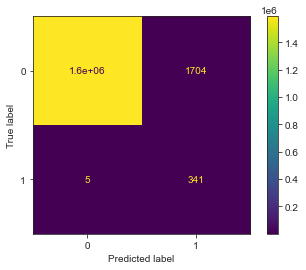

In [42]:
y_pred = logistic_model.predict(X_test)

sns.set_style("ticks")
cm = confusion_matrix(y_pred, y_test)
ConfusionMatrixDisplay(cm).plot()

print('Logistic Regression Model:\t\n',
      '\nAccuracy:\t',accuracy_score(y_test, y_pred)*100,
      '\nPrecision:\t',precision_score(y_test, y_pred)*100,
      '\nRecall: \t',recall_score(y_test, y_pred)*100,
      '\nF1-Score: \t',f1_score(y_test, y_pred)*100,)

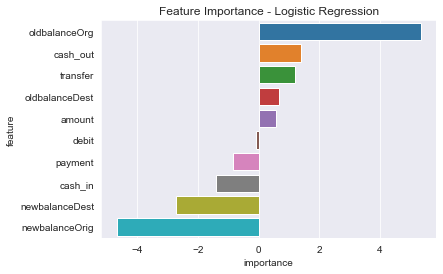

In [43]:
sns.set_style("darkgrid")
importance_df = pd.DataFrame({'feature': ['cash_in', 'cash_out', 'debit', 'payment', 'transfer', 'amount',
                              'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'],
                              'importance': logistic_model.coef_[0]}).sort_values('importance', ascending=False)

plt.title('Feature Importance - Logistic Regression')
sns.barplot(data=importance_df, x='importance', y='feature');

* Looks like the **model is preforming quite well**.
* It is doing a **good job of predicting fraudulent transactions** (high Precision).
* But it has **low Recall**.
* Lets see if this **can be imporved by using other models**.

#### **B. Decision Trees**

In [44]:
%%time
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=50)
dt_model.fit(X_train, y_train)

Wall time: 30.5 s


DecisionTreeClassifier(random_state=50)

Decision Tree Model:	
 
Accuracy:	 99.9317262385621 
Precision:	 92.62222222222222 
Recall: 	 50.95354523227383 
F1-Score: 	 65.74132492113564


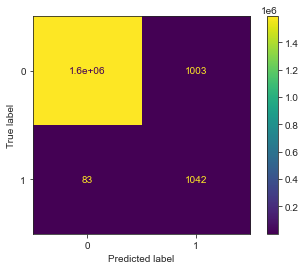

In [45]:
y_pred = dt_model.predict(X_test)

sns.set_style("ticks")
cm = confusion_matrix(y_pred, y_test)
ConfusionMatrixDisplay(cm).plot()

print('Decision Tree Model:\t\n',
      '\nAccuracy:\t',accuracy_score(y_test, y_pred)*100,
      '\nPrecision:\t',precision_score(y_test, y_pred)*100,
      '\nRecall: \t',recall_score(y_test, y_pred)*100,
      '\nF1-Score: \t',f1_score(y_test, y_pred)*100,)

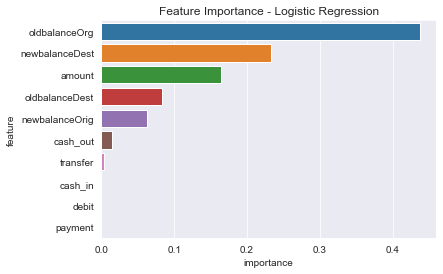

In [46]:
sns.set_style("darkgrid")
importance_df = pd.DataFrame({'feature': ['cash_in', 'cash_out', 'debit', 'payment', 'transfer', 'amount',
                              'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'],
                              'importance': dt_model.feature_importances_}).sort_values('importance', ascending=False)

plt.title('Feature Importance - Logistic Regression')
sns.barplot(data=importance_df, x='importance', y='feature');

#### **C. Random Forests**

In [47]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_jobs=-1, random_state=50)
rf_model.fit(X_train, y_train)

Wall time: 2min 39s


RandomForestClassifier(n_jobs=-1, random_state=50)

Random Forest Model:	
 
Accuracy:	 99.94964338590077 
Precision:	 97.26443768996961 
Recall: 	 62.59168704156479 
F1-Score: 	 76.16780720023803


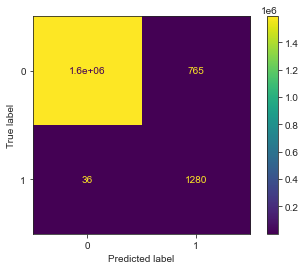

In [48]:
y_pred = rf_model.predict(X_test)

sns.set_style("ticks")
cm = confusion_matrix(y_pred, y_test)
ConfusionMatrixDisplay(cm).plot()

print('Random Forest Model:\t\n',
      '\nAccuracy:\t',accuracy_score(y_test, y_pred)*100,
      '\nPrecision:\t',precision_score(y_test, y_pred)*100,
      '\nRecall: \t',recall_score(y_test, y_pred)*100,
      '\nF1-Score: \t',f1_score(y_test, y_pred)*100,)

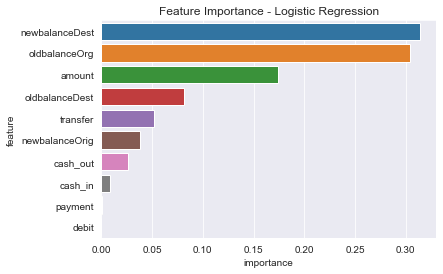

In [49]:
sns.set_style("darkgrid")
importance_df = pd.DataFrame({'feature': ['cash_in', 'cash_out', 'debit', 'payment', 'transfer', 'amount',
                              'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'],
                              'importance': rf_model.feature_importances_}).sort_values('importance', ascending=False)

plt.title('Feature Importance - Logistic Regression')
sns.barplot(data=importance_df, x='importance', y='feature');

#### **D. XG Boost**

In [50]:
%%time
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_jobs=-1, n_estimators=24, max_depth=3, random_state=50)
xgb_model.fit(X_train, y_train)

Wall time: 14.5 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=24, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=50, ...)

XG Boost Model:	
 
Accuracy:	 99.88124389009559 
Precision:	 68.6602870813397 
Recall: 	 14.034229828850856 
F1-Score: 	 23.304912708079577


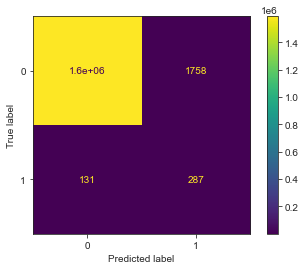

In [51]:
y_pred = xgb_model.predict(X_test)

sns.set_style("ticks")
cm = confusion_matrix(y_pred, y_test)
ConfusionMatrixDisplay(cm).plot()

print('XG Boost Model:\t\n',
      '\nAccuracy:\t',accuracy_score(y_test, y_pred)*100,
      '\nPrecision:\t',precision_score(y_test, y_pred)*100,
      '\nRecall: \t',recall_score(y_test, y_pred)*100,
      '\nF1-Score: \t',f1_score(y_test, y_pred)*100,)

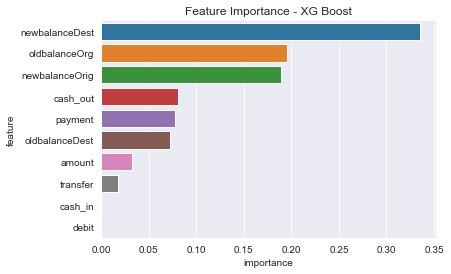

In [52]:
sns.set_style("darkgrid")
importance_df = pd.DataFrame({'feature': ['cash_in', 'cash_out', 'debit', 'payment', 'transfer', 'amount',
                              'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'],
                              'importance': xgb_model.feature_importances_}).sort_values('importance', ascending=False)

plt.title('Feature Importance - XG Boost')
sns.barplot(data=importance_df, x='importance', y='feature');

#### **E. Support Vector Machine**

In [35]:
%%time
from sklearn.svm import SVC

model = SVC(C=1)
model.fit(X_train, y_train)

Wall time: 1h 52min 52s


SVC(C=1)

In [36]:
y_pred = model.predict(X_test)

In [43]:
print( 
    'Accuracy:\t',accuracy_score(y_test, y_pred)*100,
    '\nPrecision:\t',precision_score(y_test, y_pred)*100,
    '\nRecall: \t',recall_score(y_test, y_pred)*100,
    '\nF1-Score: \t',f1_score(y_test, y_pred)*100,)

Accuracy:	 99.92826854346166 
Precision:	 99.34497816593887 
Recall: 	 44.49877750611247 
F1-Score: 	 61.46572104018912


### **7. Results, Insights and Answering Questions**

* It looks like the **Random Forest Model performed the best** with a F-1 Score of 76.16
* Unfortunately, I did not get enough time to apply hyperparameter tuning, but that would be done using GridSearchCV to find the best ones for each model.


* As for the most important features, they are the **balance of the sender before the transaction** (oldbalanceOrg), the **balance of the receiver after the transaction** (newbalanceDest), and the **amount** of the transaction.
* This **does make some sense** as all of these are vital components of any transaction.
* **Further analysis** on these features would probably **reveal more information** on why the models give the most importance to them.
* Some other features like the type of transactions ('debit', 'transfer', 'cash_out' etc) do have some importance, but not as expected.

**What kind of prevention should be adopted while company update its infrastructure?**
* Each transaction should probably be **accompanied with a very efficient rule-based safety-net to prematurely determine fraudulent transactions**.
* These possible **fraudulent transactions can then be passed to our model**, as it is quite accurate to classify frauds.
* **Though modern ML models are quite efficient** in their inference times and predicting outcomes, **passing every transaction through the model might lead to slow down the rate of transactions**, thus the preliminary rule-based approach.

**Assuming these actions have been implemented, how would you determine if they work?**
* Some sort of rigorous testing would have to be done, maybe in a simulation.
* Also the **models will have have to be thoroughly tested on never before seen data** before it can be trusted and put into production.